# This notebook answers the following:
1) What’s the best way to measure the impact of the campaign? What would be a good data-driven framework?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.formula.api import ols
import plotly.express as px

# Common Methods in Marketing Measurement

Several methods are commonly used to measure marketing impact:

1. **A/B Testing**: 
   - Compares two versions of a marketing asset to determine which performs better.
   - Useful for optimizing specific elements of a campaign.

2. **Time Series Analysis**: 
   - Examines how metrics change over time in relation to marketing activities.
   - Helps identify trends, seasonality, and campaign effects.

3. **Regression Analysis**: 
   - Models the relationship between marketing inputs and business outcomes.
   - Can control for multiple variables to isolate marketing effects.

4. **Difference-in-Differences (DiD)**: 
   - Compares the difference in outcomes between a treatment group and a control group, before and after a marketing intervention.
   - Useful for measuring the causal impact of large-scale campaigns.

5. **Marketing Mix Modeling (MMM)**: 
   - Uses statistical analysis to estimate the impact of various marketing tactics on sales or other KPIs.
   - Helps optimize marketing mix across different channels.

6. **Multi-Touch Attribution**: 
   - Assigns credit to various marketing touchpoints in the customer journey.
   - Useful for understanding the effectiveness of different channels in driving conversions.

Each method has its strengths and is suited to different scenarios, depending on the nature of the campaign and available data.

# I will touch on MMM in a different notebook - here I will focus on DiD. Why?
   - DiD allows us to estimate causal effects when randomized controlled trials are not feasible.
   - In our case, we can't randomly assign the TweetX campaign to cities, making DiD a valuable alternative.
   - DiD accounts for pre-existing differences between treatment and control cities.
   - DiD leverages data from before and after the campaign launch.

    More on the method below
    



# First Proposed Framework: Difference-in-Differences (DiD) Analysis
## 
Explanation of DiD Method
The Difference-in-Differences (DiD) method is a statistical technique used to estimate the effect of a specific intervention (like our TweetX campaign from the task) by comparing the changes in outcomes over time between a treatment group (cities where we implement the campaign) and a control group (cities where we don't).
Why DiD is Suitable for the TweetX Campaign:

1. We have data before the campaign launch (2023-09-18) and will have data after it launches.
2. We can select certain cities for the campaign, creating natural treatment and control groups based on the data given in the task.
3. It accounts for pre-existing differences between cities.
4. It controls for time trends that affect all cities similarly.

## Assumptions and Limitations of DiD
### Key Assumptions:

- Parallel Trends: The treatment and control groups would have followed the same trend in the absence of treatment.
- No Spillover Effects: The treatment doesn't affect the control group.
- No Composition Changes: The composition of treatment and control groups remains stable.
- Common Shocks: Any external factors affect both groups equally (of course these are different cities, but we need to make this assumption for the sake of the experiment).

## Limitations:

- Sensitive to violation of assumptions, especially parallel trends.
- May not capture non-linear trends well.

## Setting Up the Experiment
### Treatment Group (TweetX Campaign Cities):
Based on the EDA, I think ideally, we should split similar cities between treatment and control groups. Here's why:

1. Reduced Bias: This approach minimizes the risk of systematic differences between groups, which could skew our results.
2. Strengthened Parallel Trends Assumption: By having similar cities in both groups, we increase the likelihood that the parallel trends assumption holds.
3. Increased Robustness: This method makes our analysis more resistant to city-specific trends or shocks.
4. Better Generalizability: Results are likely to be more representative of the overall impact across different city types.

Based on this, the following groups could be considered:

### Treatment Group:

- Warsaw
- Krakow
- Bydgoszcz
- Czestochowa

### Control Group:

- Poznan
- Zabrze
- Gdansk
- Szczecin

## Data Requirements and Collection Strategy
### Data Needed for Analysis:

1. Daily ride counts for all cities (treatment and control)
2. Daily ad spend on TweetX for each treatment city
3. Daily new user signups
4. Weather data (as a control variable)
5. Local events calendar (as a control variable)
6. Global and national events calendar (again, as a control variable)

## Data Collection Strategy:

- Set up automated daily data pulls from Bolt's ride database - could be a script
- Integrate TweetX campaign data into the analysis dataset
- Collect weather data from a reliable API
- Create a system to log events that might affect ride demand or get it from a different stakeholder cell at Bolt
- Implement data quality checks to ensure consistency and completeness

# Additionally - to measure effectiveness of the campaigns we should also analyze metrics such as:

1. Customer Acquisition Cost which is the cost to acquire a new customer (through TweetX campaign in our case).
Formula for CAC = Total Campaign Cost / Number of New Customers
What we could is:

- Compare to other marketing channels
- Track over time for efficiency

2. Return on Advertising Spend - ROAS is the most common metric used in business and of course we want to know the revenue earned per euro spent on TweetX campaign.
Calculation: ROAS = Campaign Revenue / Campaign Cost

3. Incremental Cost Per Acquisition (iCPA)
Definition: Cost to acquire an additional customer solely due to TweetX campaign.
iCPA = Campaign Cost / (New Customers in Test Group - New Customers in Control Group)

We coould then compare it with regular CPA for true growth cost
Furthermore, it could be used to set campaign budget limits




# First let's see DiD in action for the Snapchat campaign

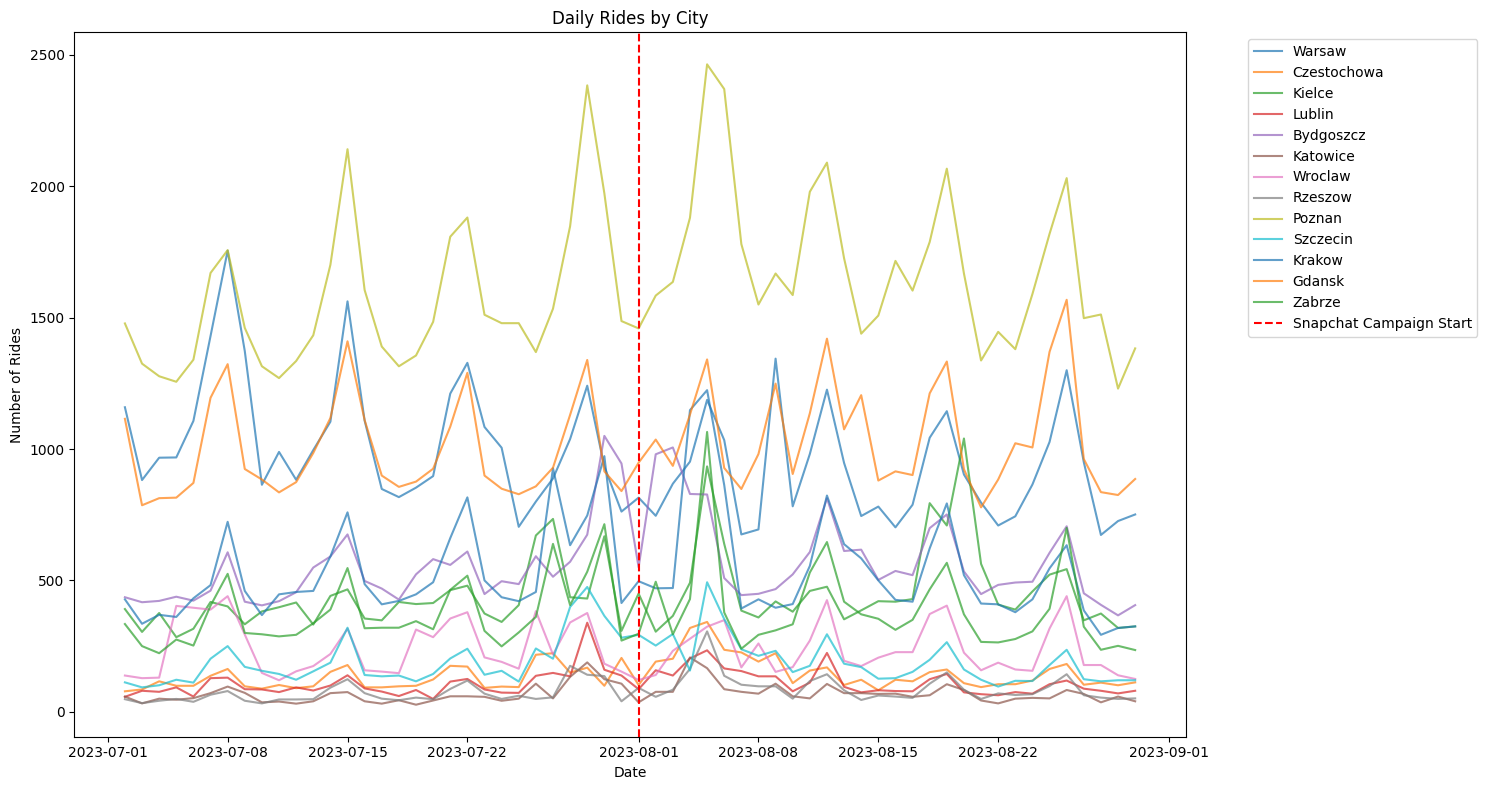

                            OLS Regression Results                            
Dep. Variable:                  rides   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     267.3
Date:                Wed, 31 Jul 2024   Prob (F-statistic):               0.00
Time:                        17:37:03   Log-Likelihood:                -5015.6
No. Observations:                 780   AIC:                         1.008e+04
Df Residuals:                     754   BIC:                         1.020e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

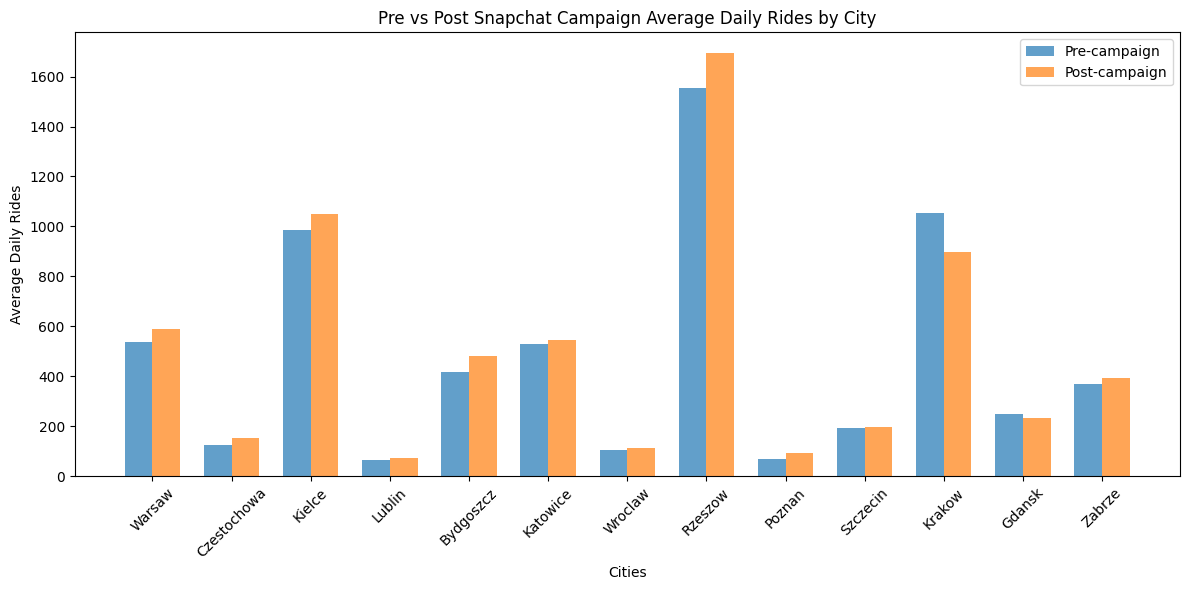

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols

df = pd.read_csv(r'C:\Users\kaczm\Desktop\Bolt Marketing\Test Task - Marketing Measurement - DF.csv')
df['date'] = pd.to_datetime(df['date'])
campaign_start = '2023-08-01'  # snapchat campaign start date accoridng to the doc I got

# 
cities = df.columns[1:]  
df_long = df.melt(id_vars=['date'], value_vars=cities, var_name='city', value_name='rides')
df_long['post_campaign'] = (df_long['date'] >= campaign_start).astype(int)

pre_campaign_start = pd.to_datetime(campaign_start) - pd.Timedelta(days=30)
post_campaign_end = pd.to_datetime(campaign_start) + pd.Timedelta(days=30)

df_analysis = df_long[(df_long['date'] >= pre_campaign_start) & (df_long['date'] < post_campaign_end)]

plt.figure(figsize=(15, 8))
for city in cities:
    city_data = df_analysis[df_analysis['city'] == city]
    plt.plot(city_data['date'], city_data['rides'], label=city, alpha=0.7)

plt.axvline(x=pd.to_datetime(campaign_start), color='r', linestyle='--', label='Snapchat Campaign Start')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Daily Rides by City')
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.tight_layout()
plt.show()

model = ols('rides ~ city + post_campaign + city:post_campaign', data=df_analysis).fit()
print(model.summary())

print("\nSnapchat Campaign Impacts by City:")
for city in cities:
    city_data = df_analysis[df_analysis['city'] == city]
    pre_campaign = city_data[city_data['post_campaign'] == 0]['rides'].mean()
    post_campaign = city_data[city_data['post_campaign'] == 1]['rides'].mean()
    impact = post_campaign - pre_campaign
    percent_change = (impact / pre_campaign) * 100
    print(f"{city}:")
    print(f"  Pre-campaign average: {pre_campaign:.2f}")
    print(f"  Post-campaign average: {post_campaign:.2f}")
    print(f"  Absolute impact: {impact:.2f}")
    print(f"  Percent change: {percent_change:.2f}%")

overall_pre = df_analysis[df_analysis['post_campaign'] == 0]['rides'].mean()
overall_post = df_analysis[df_analysis['post_campaign'] == 1]['rides'].mean()
overall_impact = overall_post - overall_pre
overall_percent_change = (overall_impact / overall_pre) * 100

print(f"\nOverall Snapchat Campaign Impact:")
print(f"  Pre-campaign average: {overall_pre:.2f}")
print(f"  Post-campaign average: {overall_post:.2f}")
print(f"  Absolute impact: {overall_impact:.2f}")
print(f"  Percent change: {overall_percent_change:.2f}%")

plt.figure(figsize=(12, 6))
pre_averages = df_analysis[df_analysis['post_campaign'] == 0].groupby('city')['rides'].mean()
post_averages = df_analysis[df_analysis['post_campaign'] == 1].groupby('city')['rides'].mean()

x = range(len(cities))
width = 0.35

plt.bar([i - width/2 for i in x], pre_averages, width, label='Pre-campaign', alpha=0.7)
plt.bar([i + width/2 for i in x], post_averages, width, label='Post-campaign', alpha=0.7)

plt.xlabel('Cities')
plt.ylabel('Average Daily Rides')
plt.title('Pre vs Post Snapchat Campaign Average Daily Rides by City')
plt.xticks(x, cities, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Now let's have a look at how a hypothetical DiD analysis could look like (in brief) for control and treatments groups for TweetX campaign

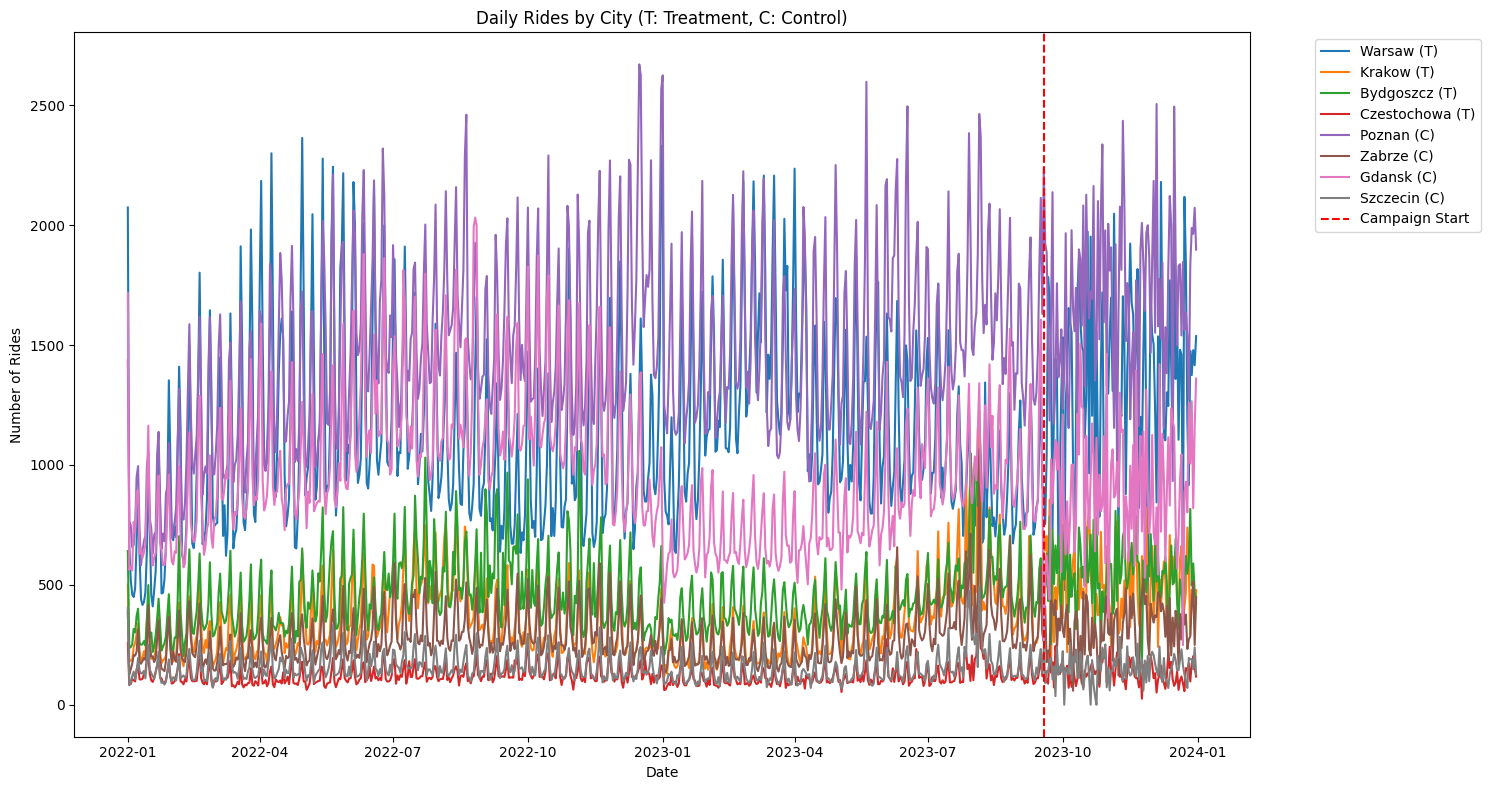

                            OLS Regression Results                            
Dep. Variable:                  rides   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     1545.
Date:                Wed, 31 Jul 2024   Prob (F-statistic):               0.00
Time:                        13:25:32   Log-Likelihood:                -42890.
No. Observations:                5840   AIC:                         8.579e+04
Df Residuals:                    5835   BIC:                         8.582e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

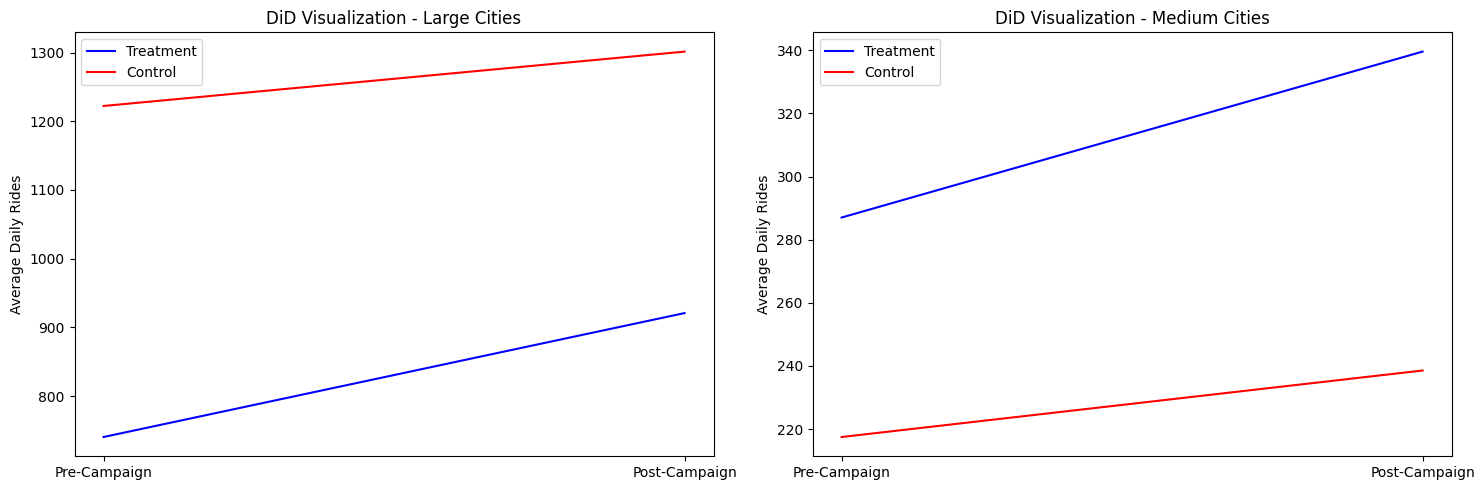

DiD Estimates by City Size:
Large cities: 101.26
Medium cities: 31.50
Overall DiD Estimate: 66.38


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols

df = pd.read_csv(r'C:\Users\kaczm\Desktop\Bolt Marketing\Test Task - Marketing Measurement - DF.csv')
df['date'] = pd.to_datetime(df['date'])
campaign_start = '2023-09-18'
df_pre = df[df['date'] < campaign_start]


treatment_cities = ['Warsaw', 'Krakow', 'Bydgoszcz', 'Czestochowa']
control_cities = ['Poznan', 'Zabrze', 'Gdansk', 'Szczecin']

city_sizes = {
    'Warsaw': 'large', 'Krakow': 'large', 'Poznan': 'large', 'Gdansk': 'large',
    'Bydgoszcz': 'medium', 'Czestochowa': 'medium', 'Zabrze': 'medium', 'Szczecin': 'medium'
}
data_pre = []
for city in treatment_cities + control_cities:
    city_data = df_pre[['date', city]].rename(columns={city: 'rides'})
    city_data['city'] = city
    city_data['treatment'] = city in treatment_cities
    city_data['size'] = city_sizes[city]
    data_pre.append(city_data)

df_long_pre = pd.concat(data_pre, ignore_index=True)
df_long_pre['post_campaign'] = 0  

# we will also neeed to create siome syntethic data for the post campaign period just for the purpose of this task to showcase how this data framew works
last_date = df_long_pre['date'].max()
date_range = pd.date_range(start=last_date + pd.Timedelta(days=1), end='2023-12-31')

data_post = []
for city in treatment_cities + control_cities:
    city_pre_data = df_long_pre[df_long_pre['city'] == city]
    X = (city_pre_data['date'] - city_pre_data['date'].min()).dt.days
    y = city_pre_data['rides']
    trend, intercept = np.polyfit(X, y, 1)
    noise_std = np.std(y - (trend * X + intercept))

    X_post = (date_range - city_pre_data['date'].min()).days
    baseline = trend * X_post + intercept
    noise = np.random.normal(0, noise_std, len(X_post))
    rides = baseline + noise
    if city in treatment_cities:
        campaign_effect = np.random.uniform(0.1, 0.2) * baseline  
        rides += campaign_effect
    
    city_post_data = pd.DataFrame({
        'date': date_range,
        'city': city,
        'rides': np.maximum(rides, 0),  
        'treatment': city in treatment_cities,
        'size': city_sizes[city],
        'post_campaign': 1
    })
    data_post.append(city_post_data)

df_long_post = pd.concat(data_post, ignore_index=True)

df_long = pd.concat([df_long_pre, df_long_post], ignore_index=True)

# and now visualize
plt.figure(figsize=(15, 8))
for city in treatment_cities + control_cities:
    city_data = df_long[df_long['city'] == city]
    plt.plot(city_data['date'], city_data['rides'], 
             label=f"{city} ({'T' if city in treatment_cities else 'C'})")

plt.axvline(x=pd.to_datetime(campaign_start), color='r', linestyle='--', label='Campaign Start')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Daily Rides by City (T: Treatment, C: Control)')
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.tight_layout()
plt.show()

model = ols('rides ~ treatment + post_campaign + treatment:post_campaign + size', data=df_long).fit()
print(model.summary())
plt.figure(figsize=(15, 5))
for i, size in enumerate(['large', 'medium']):
    plt.subplot(1, 2, i+1)
    size_data = df_long[df_long['size'] == size]
    
    treatment_pre = size_data[(size_data['treatment'] == True) & (size_data['post_campaign'] == 0)]['rides'].mean()
    treatment_post = size_data[(size_data['treatment'] == True) & (size_data['post_campaign'] == 1)]['rides'].mean()
    control_pre = size_data[(size_data['treatment'] == False) & (size_data['post_campaign'] == 0)]['rides'].mean()
    control_post = size_data[(size_data['treatment'] == False) & (size_data['post_campaign'] == 1)]['rides'].mean()

    plt.plot([0, 1], [treatment_pre, treatment_post], 'b-', label='Treatment')
    plt.plot([0, 1], [control_pre, control_post], 'r-', label='Control')
    plt.xticks([0, 1], ['Pre-Campaign', 'Post-Campaign'])
    plt.ylabel('Average Daily Rides')
    plt.title(f'DiD Visualization - {size.capitalize()} Cities')
    plt.legend()

plt.tight_layout()
plt.show()

print("DiD Estimates by City Size:")
for size in ['large', 'medium']:
    size_data = df_long[df_long['size'] == size]
    treatment_pre = size_data[(size_data['treatment'] == True) & (size_data['post_campaign'] == 0)]['rides'].mean()
    treatment_post = size_data[(size_data['treatment'] == True) & (size_data['post_campaign'] == 1)]['rides'].mean()
    control_pre = size_data[(size_data['treatment'] == False) & (size_data['post_campaign'] == 0)]['rides'].mean()
    control_post = size_data[(size_data['treatment'] == False) & (size_data['post_campaign'] == 1)]['rides'].mean()
    did_estimate = (treatment_post - treatment_pre) - (control_post - control_pre)
    print(f"{size.capitalize()} cities: {did_estimate:.2f}")

# finally calculate overall DiD estimate
treatment_pre = df_long[(df_long['treatment'] == True) & (df_long['post_campaign'] == 0)]['rides'].mean()
treatment_post = df_long[(df_long['treatment'] == True) & (df_long['post_campaign'] == 1)]['rides'].mean()
control_pre = df_long[(df_long['treatment'] == False) & (df_long['post_campaign'] == 0)]['rides'].mean()
control_post = df_long[(df_long['treatment'] == False) & (df_long['post_campaign'] == 1)]['rides'].mean()
overall_did_estimate = (treatment_post - treatment_pre) - (control_post - control_pre)
print(f"Overall DiD Estimate: {overall_did_estimate:.2f}")

# What this could be telling us (had those results been the actual ones):

Just a few highlights:

1. Positive Impact Across the Board: All estimates are positive, suggesting that the TweetX campaign had a beneficial effect on ride numbers in both large and medium cities.
2. Larger Impact in Big Cities: The higher estimate for large cities (101.26) compared to medium cities (31.50) indicates that the campaign was more effective in larger urban areas.
3. Scale Advantages: Larger cities might have benefited from network effects or economies of scale in campaign implementation.
4. Market Maturity: Bigger cities could have more mature ride-sharing markets, making users more responsive to promotions.